<h1 style="font-size:35px;
        color:black;
        ">Lab 7 Quantum Simulation as a Search Algorithm </h1>

Prerequisites:
- [Ch.3.10 Grover's Algorithm](https://qiskit.org/textbook/ch-algorithms/grover.html)
- [Ch.2.5 Proving Universality](https://qiskit.org/textbook/ch-gates/proving-universality.html#2.2-Unitary-and-Hermitian-matrices-)

Other relevant materials:
- [Ch 6.2 in QCQI] Michael A. Nielsen and Isaac L. Chuang. Quantum Computation and Quantum Information, p255

In [7]:
from qiskit import *
from qiskit.quantum_info import Statevector, partial_trace
from qiskit.visualization import plot_state_qsphere, plot_histogram

import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la

In [2]:
sim = Aer.get_backend('qasm_simulator')

<h2 style="font-size:24px;">Part 1: Hamiltonian Simulation</h2>

<br>
<div style="background: #E8E7EB; border-radius: 5px;
-moz-border-radius: 5px;">
  <p style="background: #800080;
            border-radius: 5px 5px 0px 0px;
            padding: 10px 0px 10px 10px;
            font-size:18px;
            color:white;
            "><b>Goal</b></p>
    <p style=" padding: 0px 0px 10px 10px;
              font-size:16px;"> In this lab, we consider changes to a quantum state veiwed as an evolution process generated by a given Hamiltonian. For a specified Hamiltonian, there is a corresponding unitary operator that determines the final state for any given initial state. 
    </p>
</div>

For an initial state, $|\psi(0)\rangle$ and a time independent Hamiltonian $H$ , the final state $|\psi(t)\rangle$ is $|\psi(t)\rangle = e^{-iHt}|\psi(0)\rangle$. Therefore, by constructing an appropriate gate for the unitary operator $e^{-iHt}$, we can build a quantum circuit that simulates the evolution of the quantum state $|\psi\rangle$.

<h3 style="font-size: 20px">1. Build a quantum circuit for a given Hamiltonian. </h3>

When the hamiltonian $H$ and the initial state of the system, $|\psi(0)\rangle$, are given by

$H = |0\rangle\langle0| + |+\rangle\langle+|, ~~~~ |\psi(0)\rangle = |+\rangle = \frac{1}{\sqrt 2}(|0\rangle + |1\rangle)$.

Build the circuit with two qubits to evolve the state, $|\psi(0\rangle$, by $H$ for a time $\Delta t = \theta$, where the state of the system is encoded on the 0th qubit and the 1st qubit is an ancilla.  Then, the final state $|\psi(\theta)\rangle$ is $|\psi(\theta)\rangle = e^{-i\theta ~ ( |0\rangle\langle0| ~ + ~ |+\rangle\langle+| )}~|\psi(0)\rangle$.

<h4 style="font-size: 17px">&#128211;Step A. Show that the gate H1 from the following circuit performs the operation $e^{-i\frac{\pi}{9}|0\rangle\langle0|}$ on the 0th qubit when the state of the system is encoded on the 0th qubit and the 1st qubit, ancilla, is set to the $|0\rangle$ state.</h4>

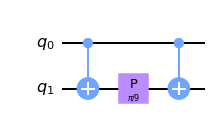

In [3]:
h1 = QuantumCircuit(2, name = 'H1')

h1.cnot(0, 1)
h1.p(np.pi/9, 1)
h1.cnot(0, 1)

H1 = h1.to_gate()

h1.draw('mpl')

**Your Solution**:



<h4 style="font-size: 17px">&#128211;Step B. Construct the gate H2 by completing the following code for the circuit `h2` to performs the operation $e^{-i\frac{\pi}{9}|+\rangle\langle+|}$ on the 0th qubit when the state of the system is encoded on the 0th qubit and the 1st qubit, ancilla, is set to the $|0\rangle$ state. </h4>

In [4]:
h2 = QuantumCircuit(2, name='H2')

#### Your code goes here ###







#############################

H2 = h2.to_gate()

h2.draw('mpl')

<h3 style="font-size: 20px">2. Execute the cell below to generate the state of the 0th qubit after every iteration.

The circuit performs $(H1H2)^7|+\rangle = (~ e^{-i\frac{\pi}{9} ~ |0\rangle\langle0|}e^{-i\frac{\pi}{9}~|+\rangle\langle+|} ~)^7~|+\rangle$ on the 0th qubit.  The state of the 0th qubit after each `H1H2` operation is stored in the list variable 'myst'.

In [1]:
from qiskit.quantum_info import Statevector, partial_trace

def st_out(qc):
    out = Statevector.from_instruction(qc)
    out_red = partial_trace(out, [1])
    prob, st_all = la.eig(out_red.data)
    cond = (prob>0.99) & (prob<1.01)
    st = st_all[:, cond].ravel()
    
    return(st)
    
myst = []

circ = QuantumCircuit(2)
circ.h(0)
st = st_out(circ)
myst.append(Statevector(st))

for _ in range(7):
    circ.append(H1, range(2))
    circ.append(H2, range(2))
    st = st_out(circ)
    myst.append(Statevector(st))
    
circ.draw('mpl') 

The following Bloch sphere picture shows the evolution of the 0th qubit state. As it shows, the state starts from the $|+\rangle$ state rotate toward to and passes the $|0\rangle$ state.  Therefore, with appropriate the angle of the `H1` and `H2` operations, $|+\rangle$ state evolves to $|0\rangle$ state by applying $H1H2 = e^{-i\theta ~ |0\rangle\langle0|}e^{-i\theta~|+\rangle\langle+|}$ proper number of times. 

<img src="image/L7_bloch_sphere.png" alt="Drawing" style="width: 300px; float: left!important;">

If you have installed `kaleidoscope` or run this lab on [IQX](https://quantum-computing.ibm.com), you can excute the cell below to visualize the state evolution through the interactive bloch sphere. 

In [11]:
from kaleidoscope import bloch_sphere
from matplotlib.colors import LinearSegmentedColormap, rgb2hex

cm = LinearSegmentedColormap.from_list('graypurple', ["#999999", "#AA00FF"])
vectors_color = [rgb2hex(cm(kk)) for kk in np.linspace(-1,1,len(myst))]
bloch_sphere(myst, vectors_color = vectors_color)

<h2 style="font-size:24px;">Part 2: Quantum Search as a Quantum Simulation</h2>

<br>
<div style="background: #E8E7EB; border-radius: 5px;
-moz-border-radius: 5px;">
  <p style="background: #800080;
            border-radius: 5px 5px 0px 0px;
            padding: 10px 0px 10px 10px;
            font-size:18px;
            color:white;
            "><b>Goal</b></p>
    <p style=" padding: 0px 0px 10px 10px;
              font-size:16px;"> In this part of the lab, we solve a search problem through quantum simulation.
    </p>
</div>

In Part1, we showed that the Hamiltonian, $H$, transforms the state, $|\psi_i\rangle$,  to $|\psi_j\rangle$ when its structure depends on both states as $ H =|\psi_j\rangle\langle\psi_j| + |\psi_i\rangle\langle\psi_i| $ with a proper time duration. 

Considering a search problem with a unique solution, we should be able to find the solution with the form of the Hamiltonian, $ H = |x\rangle\langle x| + |\psi\rangle\langle\psi|, $ when all possible items are encoded in a superposition state $|\psi\rangle$ and given as the initial state, same as in Grover's algorithm, while $|x\rangle$ represents the unknown solution. 

Applying the unitary operator, $U = e^{-iH\Delta t}$ on the initial state, $|\psi\rangle$, right number of times with the properly chosen $\Delta t$, should evolve the state $|\psi\rangle$ into the solution $|x\rangle$ or close enough to it. The following code constructs the oracle gate for the search problem.  Execute the cell below. 

In [12]:
n = 5
qc = QuantumCircuit(n+1, name='Oracle')
qc.mct(list(range(n)), n)

Oracle = qc.to_gate()

The following circuit encodes the phase $\pi$ on the solution state and zero on the other items through phase kickback with the 5th qubit as an ancilla. Therefore, the output state of the circuit is $(|\psi\rangle - |x\rangle) + e^{i\pi}|x\rangle$, which can be confirmed visually using a qsphere plot where the color indicates the phase of each basis state. Run the following two cells. 

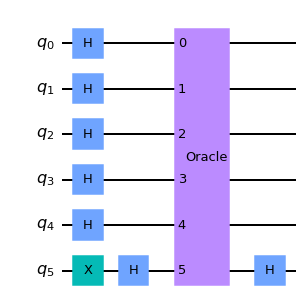

In [13]:
test = QuantumCircuit(n+1)
test.x(n)
test.h(range(n+1))
test.append(Oracle, range(n+1))
test.h(n)

test.draw('mpl')

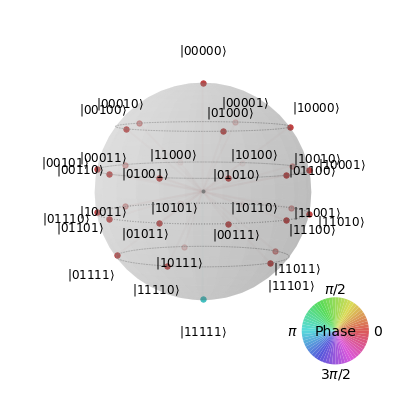

In [14]:
st = Statevector.from_instruction(test)
st_red = partial_trace(st, [5])

plot_state_qsphere(st_red)

<h3 style="font-size: 20px">1. Construct a circuit to approximate the Hamiltonian, $H = |x\rangle\langle x| + |\psi\rangle\langle\psi|$, when all possible items are encoded in a superposition state $|\psi\rangle$ and given as the initial state while $|x\rangle$ represents the unique unknown solution.</h3>

As we did in the Part1, we build the circuit for the simulation with the Hamiltonian, but with more qubits to examine all the items in the question. Regrad the search problem having one solution out of 32 items.  

<h4 style="font-size: 17px">&#128211;Step A. Construct the gate H1 performing the operation $e^{-i\Delta t|\psi\rangle\langle\psi|}$ by completing the following code.</h4>

In [15]:
def H1(delt, n=5):
    
    h1 = QuantumCircuit(n+1, name='H1')

    #### Your code goes here ######

    
   



    
    ###############################
    
    return h1.to_gate()

<h4 style="font-size: 17px">&#128211;Step B. Construct the gate H2 performing the operation $e^{-i\Delta t|x\rangle\langle x|}$ by completing the following code.</h4>

In [16]:
def H2(delt, n=5):
    
    h2 = QuantumCircuit(n+1, name='H2')

    #### Your code goes here ######

    
    
    
    
    
    
    
    
    ###############################
    
    return h2.to_gate()

<h4 style="font-size: 17px">&#128211;Step C. Create the circuit, 'sim_h', to compute $e^{-i \pi H_{app}}|\psi\rangle = (~e^{-i\pi~|x\rangle\langle x|}e^{-i\pi~|\psi\rangle\langle\psi|}~)|\psi\rangle $ which evolves the state $|\psi\rangle$ under the Hamiltonian $H = |x\rangle\langle x| + |\psi\rangle\langle\psi|$ approximately over the time duration $\Delta t = \pi$.</h4>

Th state $|\psi\rangle$ represents the superposition state of all possible items.

Utilize the gates `H1` and `H2`. 

In [2]:
#### Your code goes here ####








############

sim_h.draw('mpl')

<h3 style="font-size: 20px">2. Show that the search problem can be solved through quantum simulation with  $H_{appr}$ by verifying the two operations, Grover's algorithm and $U = e^{-i\Delta t~H_{appr}}$ with $\Delta t = \pi$, are equivalent. </h3>

<h4 style="font-size: 17px">Step A. The following circuit, `grover`, runs the Grover's algorithm for the problem to find a solution for the oracle that we built above. Run the cell below. </h4> 

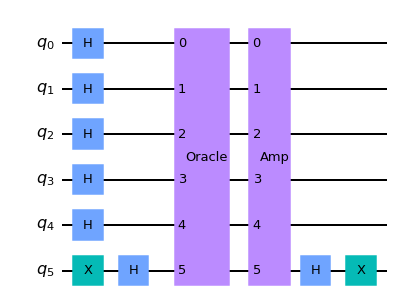

In [83]:
qc = QuantumCircuit(n+1, name='Amp')
qc.h(range(n))
qc.x(range(n))
qc.mct(list(range(n)), n)
qc.x(range(n))
qc.h(range(n))

Amp = qc.to_gate()

grover = QuantumCircuit(n+1)
grover.x(n)
grover.h(range(n+1))
grover.append(Oracle, range(n+1))
grover.append(Amp, range(n+1))
grover.h(n)
grover.x(n)

grover.draw('mpl')

<h4 style="font-size: 17px">Step B. Upon executing the cells below, the result shows that the circuits, 'grover' and 'sim_h' are identical up to a global phase. </h4>

In [8]:
st_simh = Statevector.from_instruction(sim_h)
st_grover = Statevector.from_instruction(grover)
print('grover circuit and sim_h circuit genrate the same output state: ' ,st_simh == st_grover)

In [9]:
plot_state_qsphere(st_simh)

In [10]:
plot_state_qsphere(st_grover)

<h4 style="font-size: 17px">&#128211;Step C. Find the number of the Grover interations, R, needed to find the solutions of the Oracle that we built.</h4>

In [3]:
#### your code goes here ####




######
print(R)

<h4 style="font-size: 17px">Step D. Find the solution to the serach problem, for the Oracle that we built,  through Grover's algorithm and the simulation computing $e^{-i R\pi H_{app}}|\psi\rangle = (~e^{-i\pi~|x\rangle\langle x|}e^{-i\pi~|\psi\rangle\langle\psi|}~)^R|\psi\rangle $ where R is the number of iterations.</h4>

In [4]:
## The circuit to solve the search problem through Grover's algorithm. 
n = 5 

qc_grover = QuantumCircuit(n+1, n)
qc_grover.x(n)
qc_grover.h(range(n+1))
for _ in range(int(R)):
    qc_grover.append(Oracle, range(n+1))
    qc_grover.append(Amp, range(n+1))

qc_grover.h(n)
qc_grover.x(n)
qc_grover.barrier()
qc_grover.measure(range(n), range(n))


qc_grover.draw('mpl')

&#128211; Complete the code to build the circuit, `qc_sim`,  to solve the search problem through the simulation.

In [5]:
qc_sim = QuantumCircuit(n+1, n)
qc_sim.h(range(n))

#### Your code goes here ####








Run the following cell to simulate both circuits, `qc_grover` and `qc_sim` and compare their solutions.

In [6]:
counts = execute([qc_grover, qc_sim], sim).result().get_counts()
plot_histogram(counts, legend=['Grover', 'Hamiltonian'])

<h3 style="font-size: 20px">3. The following result shows an example where the solution can be found with probability exactly equal to one through quantum simulation by the choosing the proper time duration $\Delta t$.</h3>

In [1]:
n = 5

qc = QuantumCircuit(n+1, n)
qc.h(range(n))

delt, R = np.pi/2.1, 6

for _ in range(int(R)):
    qc.append(H1(delt), range(n+1))
    qc.append(H2(delt), range(n+1))

qc.measure(range(n) ,range(n))    
#qc.draw('mpl')

![](image/L7_circ.png)

In [2]:
count = execute(qc, sim).result().get_counts()
# plot_histogram(count)

<img src="image/L7_hist.png" alt="Drawing" style="width: 450px; float: left!important;">